In [1]:
from torchvision.models import resnet50, ResNet50_Weights
import numpy as np
import os
from transform_factory import tensorize, center_crop_224, resize_322, imagenet_normalize, resize_224
from PIL import Image
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt

In [2]:
# config
seed = 0
data_num = 128
expl_method = "GradCAM"
dataset = "center_crop_224"
orig_input_method = "center_crop_224"
# expl_method = "LayerXAct"

In [3]:
model = resnet50(weights=ResNet50_Weights.DEFAULT).eval()

In [4]:
with open(f"./val_{dataset}_seed_{seed}.npy", "rb") as f:
    filepath_list = np.load(f)

orig_imgs = []
orig_expls = []


for img_path in filepath_list[:data_num]:
    img_name = os.path.basename(img_path)

    orig_img_pil = Image.open(img_path)
    orig_img = imagenet_normalize(tensorize(center_crop_224(resize_322(orig_img_pil))))

    orig_imgs.append(orig_img)

    with open(f"results/val_seed_{seed}_dataset_{dataset}_orig_input_method_{orig_input_method}_pred_orig_eval_orig_transform_both_sign_all_reduction_sum/{img_name}_expl_{expl_method}_sample_2000_sigma_0.05_seed_{seed}_orig_true_config.npy", "rb") as f:
        orig_expl = np.load(f, allow_pickle=True)
        true_expls = np.load(f, allow_pickle=True)
        configs = np.load(f, allow_pickle=True)

        orig_expl = F.interpolate(torch.tensor(orig_expl).unsqueeze(0), (224, 224), mode='bicubic').squeeze(0).numpy()

        orig_expls.append(orig_expl)


orig_imgs = torch.stack(orig_imgs)
orig_expls = torch.tensor(np.stack(orig_expls))


In [5]:
print(orig_imgs.shape)
# orig_expls.shape

torch.Size([128, 3, 224, 224])


In [6]:
y = model(orig_imgs).argmax(dim = 1)

In [66]:
class ConfAOPCTestor():
    def __init__(self, model) -> None:
        self.model = model.cuda()
        self.softmax = torch.nn.Softmax(dim = 1)

    @staticmethod
    def perturbation(expl, img, conf_high, conf_low, mode='insertion'):
        mask = torch.where(torch.logical_and(expl > 0, conf_low > 0), torch.ones_like(expl), 0)
        ratio = mask.flatten(1).sum(1) / (mask.shape[2] * mask.shape[3])
        order = expl.flatten(1).argsort(descending=True)
        
        n_perturb = (ratio * order.shape[1]).type(torch.LongTensor).squeeze()
        n_order = order[range(len(expl)), n_perturb]
        threshold = expl.flatten(1)[range(len(expl)), n_order]
        base_mask = expl > threshold.reshape(len(expl), 1, 1).unsqueeze(1)

        return (base_mask * img).detach(), (mask * img).detach()

    def test_step(self, expl, img, label, conf_high, conf_low, mode='insertion'):

        img_base, img_our = self.perturbation(expl, img, conf_high, conf_low, mode=mode)

        plt.imshow(img_base[3].sum(0))
        plt.show()
        plt.imshow(img_our[3].sum(0))

        logit = self.model(img_base.cuda())
        del img_base
        prob_base = self.softmax(logit)

        aopc_prob_base = prob_base[range(len(label)), label].detach().mean()

        logit = self.model(img_our.cuda())
        del img_our
        prob_our = self.softmax(logit)
        aopc_prob_our = prob_our[range(len(label)), label].detach().mean()

        print(aopc_prob_base, aopc_prob_our)

        # aopc_prob = prob[range(len(label)), label].detach().mean()
        # prob_list.append(aopc_prob.detach().cpu())


In [67]:

class AOPCTestor():
    def __init__(self, model) -> None:
        self.model = model
        self.softmax = torch.nn.Softmax(dim = 1)


    @staticmethod
    def perturbation(expl, img, ratio, mode="insertion"):
    # expl : [B, C=1, H, W]
    # img : [B, C=3, H, W]


        if mode == "insertion":
            order = expl.flatten(1).argsort(descending=True)
            n_perturb = int(ratio * order.shape[1])
            n_order = order[:, n_perturb] 
            threshold = expl.flatten(1)[range(len(expl)), n_order])
            mask = expl > threshold.reshape(len(expl), 1, 1).unsqueeze(1)
        elif mode == "deletion":
            order = expl.flatten(1).argsort()
            n_perturb = int(ratio * order.shape[1])
            n_order = order[:, n_perturb]
            threshold = expl.flatten(1)[range(len(expl)), n_order]
            mask = expl > threshold.reshape(len(expl), 1, 1).unsqueeze(1)        
            
        return (img * mask).detach()

    @staticmethod
    def conf_perturbation(expl, img, conf_high, conf_low, mode="insertion"):
        # expl : [B, C = 1, H, W]
        # conf_high, conf_low : [B, C=1, H, W]

        mask = torch.where(torch.logical_and(expl > 0, conf_low > 0), torch.zeros_like(expl), 1)
        ratio = mask.flatten(1).sum(1) / (mask.shape[2] * mask.shape[3])

        return (img * mask).detach()        

    def test_step(self, expl, img, label, mode="orig", conf_high = None, conf_low = None):
        prob_list = []

        if mode == "orig_pos_low_pos":
            img_p = self.conf_perturbation(expl, img, conf_high, conf_low, mode=mode)

            logit = self.model(img_p.cuda())
            del img_p
            prob = self.softmax(logit)

            aopc_prob = prob[range(len(label)), label].detach().mean()
            prob_list.append(aopc_prob.detach().cpu())
        else:
            for ratio in np.arange(0, 1, 0.05):

                img_p = self.perturbation(expl, img, ratio=ratio, mode=mode)

                logit = self.model(img_p.cuda())
                del img_p
                prob = self.softmax(logit)

                aopc_prob = prob[range(len(label)), label].detach().mean()
                prob_list.append(aopc_prob.detach().cpu())

        return prob_list

SyntaxError: unmatched ')' (122276638.py, line 17)

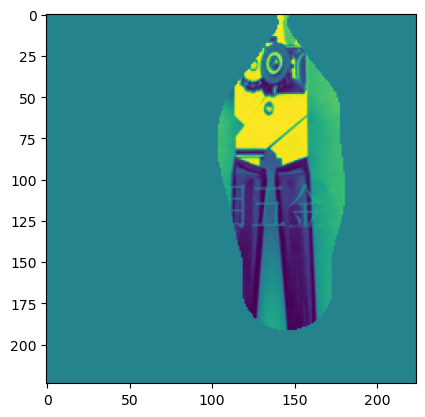

tensor(0.6128, device='cuda:0') tensor(0.5918, device='cuda:0')


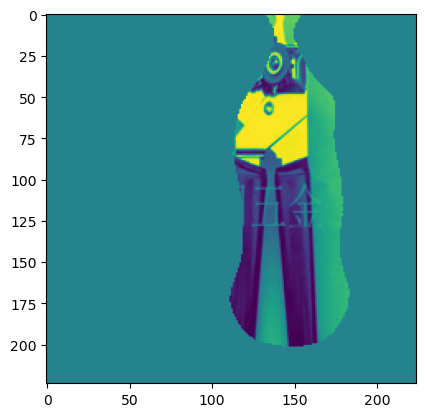

: 

In [68]:
tester = ConfAOPCTestor(model)

batch_size = 128
for i in range(2):
    tester.test_step(orig_expls[batch_size * i:batch_size * (i + 1)], 
                     orig_imgs[batch_size * i:batch_size * (i + 1)], 
                    y, conf_highs, conf_lows)

In [23]:
tester = AOPCTestor(model=model.cuda())
# prob_list = tester.test_step(orig_expls, orig_imgs, y, mode="insertion")
# prob_list = tester.test_step(orig_expls, orig_imgs, y, mode="insertion")

prob_list = tester.test_step(orig_expls, orig_imgs, y, mode="orig_pos_low_pos", conf_low=conf_lows)


In [10]:
# prob_list_del = tester.test_step(orig_expls, orig_imgs, y, mode="deletion")
prob_list = tester.test_step(orig_expls, orig_imgs, y, mode="insertion")


In [11]:
print(prob_list, torch.stack(prob_list).mean())

[tensor(0.0012), tensor(0.0547), tensor(0.2046), tensor(0.3455), tensor(0.4667), tensor(0.5555), tensor(0.6295), tensor(0.7201), tensor(0.7863), tensor(0.8276), tensor(0.8641), tensor(0.9013), tensor(0.9090), tensor(0.9202), tensor(0.9283), tensor(0.9337), tensor(0.9362), tensor(0.9416), tensor(0.9462), tensor(0.9530)] tensor(0.6913)


In [18]:
print(prob_list_del, torch.stack(prob_list_del).mean())

[tensor(0.9662), tensor(0.9589), tensor(0.9537), tensor(0.9482), tensor(0.9441), tensor(0.9454), tensor(0.9377), tensor(0.9276), tensor(0.9152), tensor(0.9057), tensor(0.8725), tensor(0.8362), tensor(0.7947), tensor(0.7338), tensor(0.6475), tensor(0.5759), tensor(0.4884), tensor(0.3726), tensor(0.2338), tensor(0.0652)] tensor(0.7512)


In [9]:
conf_highs = []
conf_lows = []

alpha = 0.05

for img_path in filepath_list[:data_num]:
    img_name = os.path.basename(img_path)
    
    with open(f"results/val_seed_{seed}_dataset_{dataset}_orig_input_method_{orig_input_method}_pred_orig_eval_orig_transform_both_sign_all_reduction_sum/{img_name}_expl_{expl_method}_sample_2000_sigma_0.05_seed_{seed}_results.pkl", "rb") as f:
        results = np.load(f, allow_pickle=True)

    result = results[0]

    conf_highs.append(torch.tensor(result['conf_high']))
    conf_lows.append(torch.tensor(result['conf_low']))


conf_highs = torch.stack(conf_highs)
conf_lows = torch.stack(conf_lows)

/tmp/ipykernel_1473511/3417597988.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  conf_highs.append(torch.tensor(result['conf_high']))
/tmp/ipykernel_1473511/3417597988.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  conf_lows.append(torch.tensor(result['conf_low']))


In [54]:
print(orig_expls.shape)


orig_pos_low_pos = torch.where(torch.logical_and(orig_expls > 0, conf_lows > 0))
orig_pos_low_neg = torch.where(torch.logical_and(orig_expls > 0, conf_lows < 0))

orig_neg_high_pos = torch.where(torch.logical_and(orig_expls < 0, conf_highs > 0))
orig_neg_high_neg = torch.where(torch.logical_and(orig_expls < 0, conf_highs < 0))

print(len(orig_pos_low_pos[0]))
print(len(orig_pos_low_neg[0]))
print(len(orig_neg_high_pos[0]))
print(len(orig_neg_high_neg[0]))


torch.Size([128, 1, 224, 224])
1802218
3715683
904627
0


In [55]:
orig_pos_low_pos_mask = torch.where(torch.logical_and(orig_expls > 0, conf_lows > 0), torch.ones_like(orig_expls), 0.)
print(len(orig_pos_low_pos[0]))
print(orig_pos_low_pos_mask.sum())



1802218
tensor(1802218.)


In [36]:
mask = torch.where(torch.logical_and(orig_expls > 0, conf_lows > 0), torch.zeros_like(orig_expls), 1)

ratio = mask.flatten(1).sum(1) / (mask.shape[2] * mask.shape[3])
ratio

tensor([0.7530, 0.7488, 0.5969, 0.7919, 0.7222, 0.8035, 0.5526, 0.7282, 0.7212,
        0.6861, 0.7923, 0.7890, 0.7325, 0.7242, 0.6457, 0.8088, 0.7203, 0.7101,
        0.7142, 0.7289, 0.4622, 0.5870, 0.8104, 0.4638, 0.9281, 0.7597, 0.6481,
        0.7118, 0.4242, 0.7366, 0.7708, 0.8639, 0.6727, 0.7346, 0.6047, 0.4993,
        0.5197, 0.7704, 0.7844, 0.5682, 0.6887, 0.8245, 0.8860, 0.7686, 0.6399,
        0.7622, 0.7621, 0.7140, 0.8196, 0.8331, 0.6183, 0.8973, 0.6415, 0.5118,
        0.8866, 0.8838, 0.6561, 0.8387, 0.9173, 0.6878, 0.7675, 0.8637, 0.8123,
        0.7145, 0.8637, 0.7920, 0.6823, 0.7211, 0.6021, 0.8125, 0.8697, 0.7670,
        0.5601, 0.7564, 0.7905, 0.5251, 0.8445, 0.5883, 0.5785, 0.8355, 0.8085,
        0.8274, 0.7780, 0.4115, 0.6686, 0.7815, 0.6763, 0.5040, 0.5583, 0.8358,
        0.7801, 0.8702, 0.4099, 0.7685, 0.8910, 0.7099, 0.7635, 0.6757, 0.6422,
        0.7943, 0.5659, 0.9211, 0.8925, 0.5868, 0.6373, 0.7935, 0.5803, 0.9103,
        0.6012, 0.5732, 0.8800, 0.7103, 

In [17]:
print(len(orig_pos_low_pos[0]))
print(len(orig_pos_low_neg[0]))
print(len(orig_neg_high_pos[0]))
print(len(orig_neg_high_neg[0]))


1802218
3715683
904627
0


In [13]:
# tester.test_step(conf_lows, orig_imgs, y, mode='deletion')
# high_del_prob = tester.test_step(conf_highs, orig_imgs, y, mode='deletion')
high_ins_prob = tester.test_step(conf_highs, orig_imgs, y, mode='insertion')


In [14]:
# print(high_del_prob, torch.stack(high_del_prob).mean())
print(high_ins_prob, torch.stack(high_ins_prob).mean())


[tensor(0.0012), tensor(0.0410), tensor(0.1977), tensor(0.3039), tensor(0.4471), tensor(0.5468), tensor(0.6320), tensor(0.7047), tensor(0.7739), tensor(0.8071), tensor(0.8426), tensor(0.8731), tensor(0.8940), tensor(0.9191), tensor(0.9252), tensor(0.9364), tensor(0.9438), tensor(0.9492), tensor(0.9525), tensor(0.9573)] tensor(0.6824)


In [20]:
# low_ins_prob = tester.test_step(conf_lows, orig_imgs, y, mode='insertion')
low_del_prob = tester.test_step(conf_lows, orig_imgs, y, mode='deletion')

In [21]:
# print(low_ins_prob, torch.stack(low_ins_prob).mean())
print(low_del_prob, torch.stack(low_del_prob).mean())



[tensor(0.9665), tensor(0.9585), tensor(0.9415), tensor(0.9342), tensor(0.9224), tensor(0.9132), tensor(0.9035), tensor(0.8899), tensor(0.8748), tensor(0.8385), tensor(0.8206), tensor(0.7690), tensor(0.7254), tensor(0.6921), tensor(0.6275), tensor(0.5503), tensor(0.4777), tensor(0.3744), tensor(0.2526), tensor(0.1112)] tensor(0.7272)


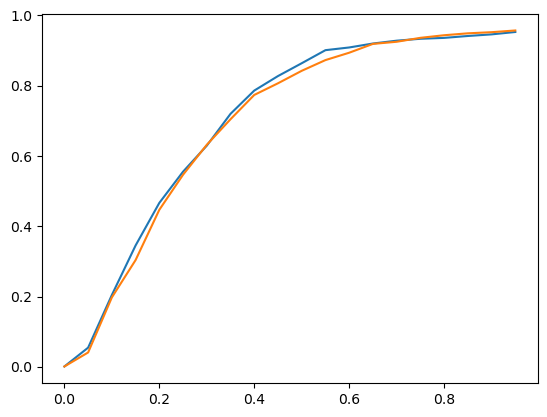

: 

In [15]:
plt.plot(np.arange(0, 1, 0.05), prob_list)
plt.plot(np.arange(0, 1, 0.05), high_ins_prob)


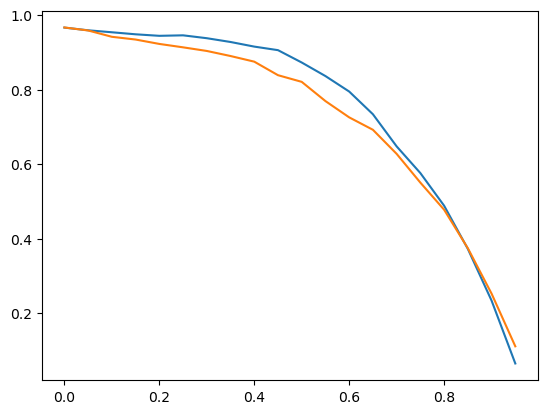

In [22]:
plt.plot(np.arange(0, 1, 0.05), prob_list_del)
plt.plot(np.arange(0, 1, 0.05), low_del_prob)